In [1]:
import matplotlib.pyplot as plt 
import random
import numpy as np
import math
from scipy.integrate import odeint
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints

#Defining functions

def StateFcn(x,dt):                     #Van der Pol func
    out = np.empty_like(x)
    out[0] = x[0] + x[1] * dt
    out[1] = x[1] + ((1 - x[0]**2) * x[1] - x[0]) * dt
    return out

def DataFunc(x,t):                     #Creates datapoints
    dxdt = [x[1], (1-x[0]**2)*x[1]-x[0]];
    return dxdt

def MeasFuncPos(x):                    #Input [x,y] returns [x] (Slicing)
    X = x[:1] 
    return X

def MeasFuncVel(x):                    #Input [x,y] returns [y]
    X = x[1:] 
    return X

#Is in matlab code, not sure what it does, seems same as creation of noisy data 
def MNoiseNonAddFcn(x,vk):
    yk = x[:1]*(1+vk)
    return yk

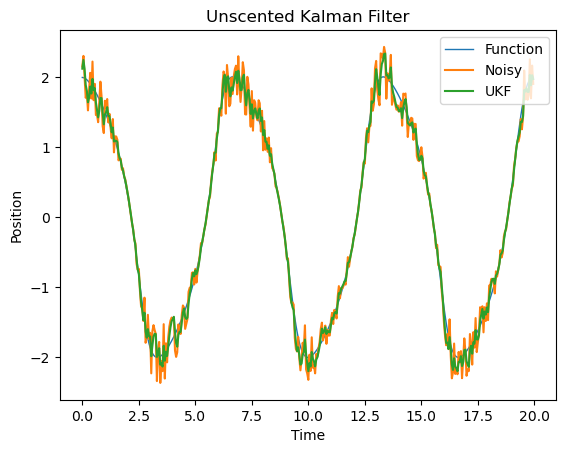

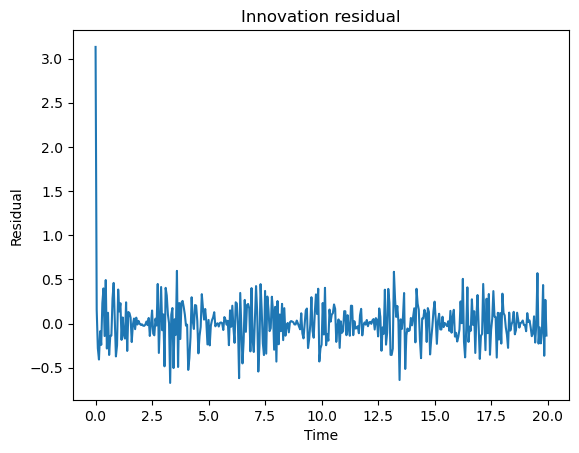

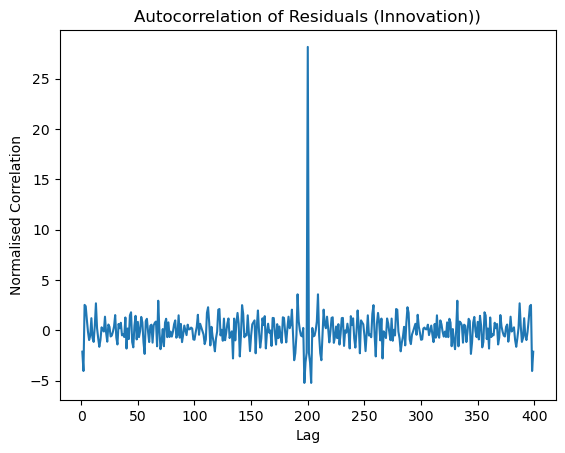

Text(0, 0.5, 'Error')

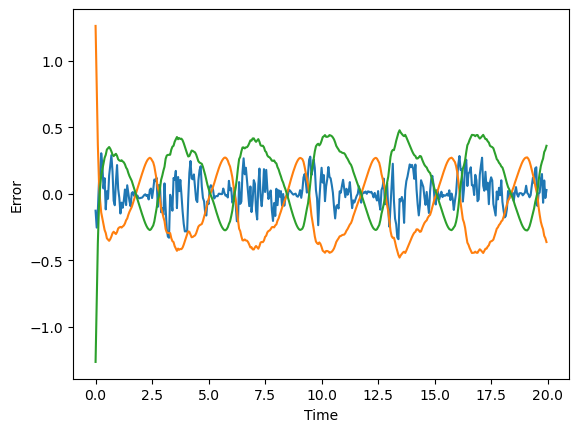

<Figure size 640x480 with 0 Axes>

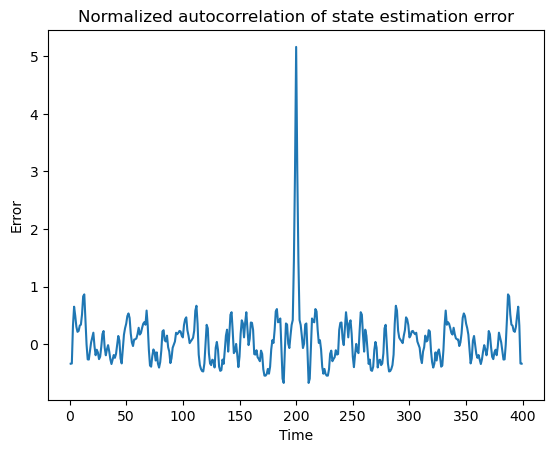

In [3]:
#Initialising
dt=0.05
t=20
time = np.arange(0, t, dt)
initial_guess = np.array([-1,0.5])    #has dims z by x
R=0.05

#Creation of ukf function
points = MerweScaledSigmaPoints(2, alpha=0.1, beta=2.0, kappa=1.0)  #Possibly built into the matlab ukf func
ukf = UnscentedKalmanFilter(2, 1, dt, MeasFuncPos, StateFcn, points)
ukf.x = initial_guess
ukf.R=R  #1x1 since dimz is 1
ukf.Q=np.diag([0.02, 0.1])  #2x2 since dimx is 2
ukf.P = np.diag([5, 5])  #Should be >> than Q as it affects the sensitivity of the filter, possibly not needed to be defined

#Keeps the same randomised values 
#np.random.seed(4)
Init = [2.0, 0.0]

#Creating the sample data using Van der Pol function and adding noise 
sol = odeint(DataFunc, Init, time)
pos = sol[:, 0]
vel = sol[:,1]
vk=np.sqrt(R)*(np.random.random(len(time))-0.5)*2  #Noise
pos_noise = pos * (1 + vk) 
vel_noise = vel * (1 + vk)    

#Initialising
steps = len(time)
xNew, pNew, residual= [] , [] , [] 

for i in range(0,steps):

    ukf.predict()
    ukf.update(pos_noise[i])
    xNew.append(ukf.x[0])
    pNew.append(ukf.P)
    residual.append(ukf.y[0])

    
#Plotting
plt.figure()
plt.plot(time,pos, linewidth=1,label='Function')
plt.plot(time,pos_noise,label='Noisy')
plt.plot(time,xNew,label='UKF')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Unscented Kalman Filter')
plt.legend(loc='upper right')


plt.figure()
plt.plot(time, residual)
plt.title('Innovation residual')
plt.xlabel('Time')
plt.ylabel('Residual')

#
xe, xeLags = np.correlate(residual, residual, mode='same'), np.arange(len(residual))
idx = xeLags > 0

plt.figure()
plt.plot(xeLags[idx], xe[idx])
plt.xlabel('Lag')
plt.ylabel('Normalised Correlation')
plt.title('Autocorrelation of Residuals (Innovation))')
plt.show()

plt.figure()
sigma = [pNew[1, 1] for pNew in pNew]   #Definitely meant to be [0,0] state, results dont match matlab if not
error = pos-xNew
plt.plot(time, error)
plt.plot(time,  -1+np.sqrt(sigma))   #Added in the +-1 to match matlab results, so not correct
plt.plot(time,  1-np.sqrt(sigma))
plt.xlabel('Time')
plt.ylabel('Error')

plt.figure()
xeState, xeLagsState = np.correlate(error, error, mode='same'), np.arange(len(residual))
idx = xeLagsState > 0

plt.figure()    #Unsure as to why massive spike in the middle 
plt.plot(xeLagsState[idx], xeState[idx])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Normalized autocorrelation of state estimation error')
plt.xlabel('Time')
plt.ylabel('Error')

Text(0.5, 1.0, 'Normalized autocorrelation of state estimation error')

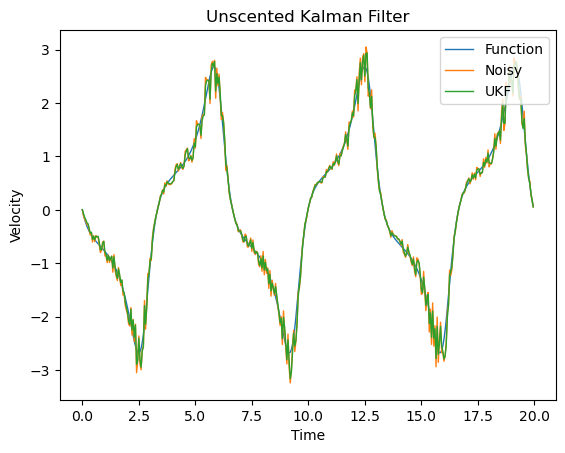

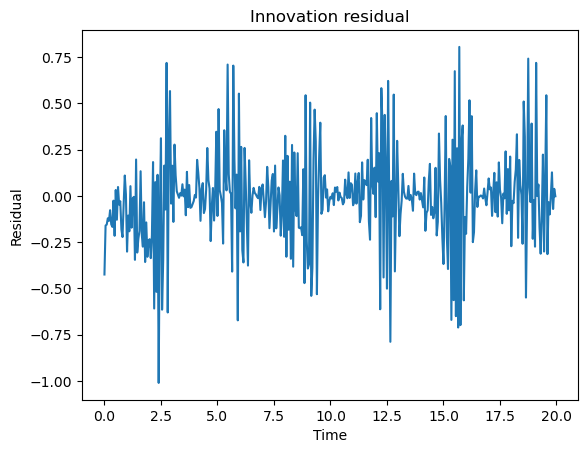

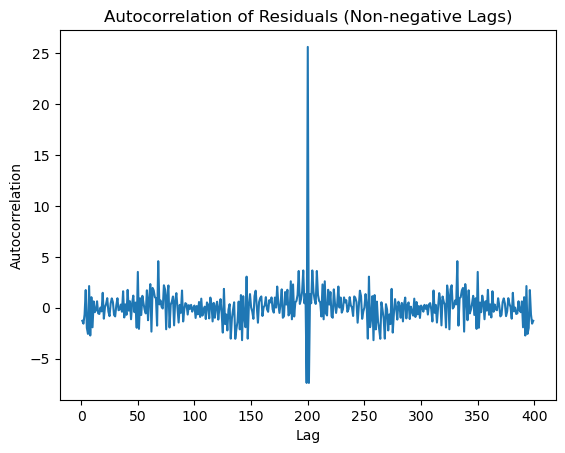

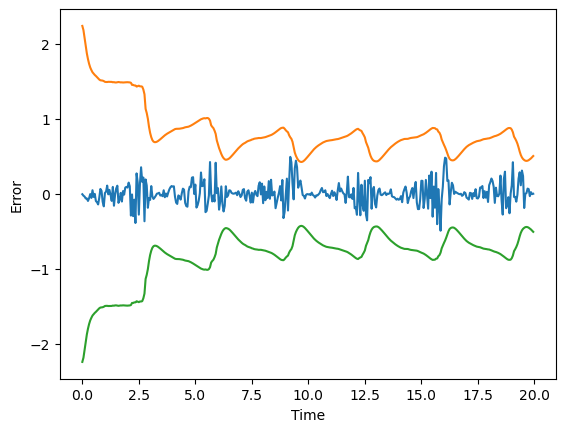

<Figure size 640x480 with 0 Axes>

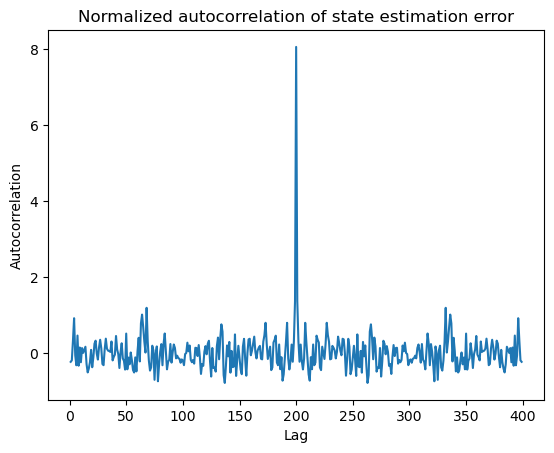

In [4]:
#Resetting, so can do for velocity
#Will make code neater once all is fully functional
#Only difference in method is the MeaasFunc and x[1]
points = MerweScaledSigmaPoints(2, alpha=0.1, beta=2.0, kappa=1.0)
ukf = UnscentedKalmanFilter(2, 1, dt, MeasFuncVel, StateFcn, points)
ukf.x = initial_guess
ukf.R=R  #1x1 since dimz is 1
ukf.Q=np.diag([0.02, 0.1])  #2x2 since dimx is 2
ukf.P = np.diag([5, 5])
vNew, pNew1, residual1 = [] , [] , []

for i in range(0,steps):
    ukf.predict()
    ukf.update(vel_noise[i])
    vNew.append(ukf.x[1])
    pNew1.append(ukf.P)
    residual1.append(ukf.y[0])
    
plt.plot(time,vel, linewidth=1,label='Function')
plt.plot(time,vel_noise,linewidth=1,label='Noisy')
plt.plot(time,vNew,linewidth=1,label='UKF')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Unscented Kalman Filter')
plt.legend(loc='upper right')

plt.figure()
plt.plot(time, residual1)
plt.title('Innovation residual')
plt.xlabel('Time')
plt.ylabel('Residual')

xe, xeLags = np.correlate(residual1, residual1, mode='same'), np.arange(len(residual1))
idx = xeLags > 0

plt.figure()
plt.plot(xeLags[idx], xe[idx])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Residuals (Non-negative Lags)')


plt.figure()
sigma = [pNew1[0, 0] for pNew1 in pNew1]
error1 = vel-vNew
plt.plot(time, error1)
plt.plot(time,  np.sqrt(sigma))
plt.plot(time,  -np.sqrt(sigma))
plt.xlabel('Time')
plt.ylabel('Error')

plt.figure()
xeState1, xeLagsState1 = np.correlate(error1, error1, mode='same'), np.arange(len(residual1))
idx = xeLagsState1 > 0

plt.figure()
plt.plot(xeLagsState1[idx], xeState1[idx])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Normalized autocorrelation of state estimation error')


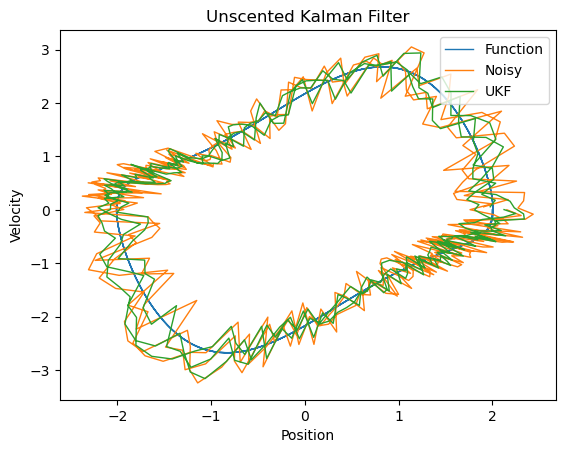

In [5]:
plt.plot(pos,vel, linewidth=1,label='Function')
plt.plot(pos_noise,vel_noise,linewidth=1,label='Noisy')
plt.plot(xNew,vNew,linewidth=1,label='UKF')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Unscented Kalman Filter')
plt.legend(loc='upper right')